# 월간 데이콘 소설 작가 분류 


- 데이콘 : https://dacon.io/competitions/open/235670/overview/description
- 평가 : logloss
- 타겟 : author

# 데이터 살펴보기

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [6]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/github/월간 데이콘 소설 작가 분류/data/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/github/월간 데이콘 소설 작가 분류/data/test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/github/월간 데이콘 소설 작가 분류/data/sample_submission.csv', encoding = 'utf-8')

In [7]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54879 entries, 0 to 54878
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   54879 non-null  int64 
 1   text    54879 non-null  object
 2   author  54879 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19617 entries, 0 to 19616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   19617 non-null  int64 
 1   text    19617 non-null  object
dtypes: int64(1), object(1)
memory usage: 306.6+ KB


(None, None)

# 컬럼

In [8]:
# 종류확인
train['index'].value_counts()

0        1
36578    1
36580    1
36581    1
36582    1
        ..
18296    1
18297    1
18298    1
18299    1
54878    1
Name: index, Length: 54879, dtype: int64

In [9]:
# 종류 확인
test['index'].value_counts()

0        1
13075    1
13082    1
13081    1
13080    1
        ..
6539     1
6538     1
6537     1
6536     1
19616    1
Name: index, Length: 19617, dtype: int64

In [10]:
# 결측치 -> 없음
print("train 데이터의 index 결측치 존재 :",train['index'].isna().any())
print("test 데이터의 index 결측치 존재 :",test['index'].isna().any())

train 데이터의 index 결측치 존재 : False
test 데이터의 index 결측치 존재 : False


- 전부 다 다른 값이며, 큰 의미를 갖지 않는다. -> `제거`

In [11]:
#del train['index']
#del test['index']

In [12]:
train['author'].value_counts()

3    15063
0    13235
2    11554
4     7805
1     7222
Name: author, dtype: int64

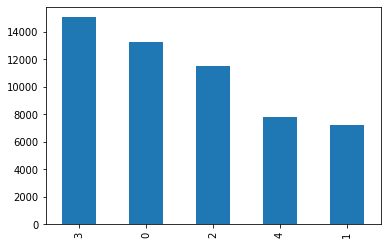

In [13]:
# 작가별 건수
train['author'].value_counts().plot(kind='bar')

In [14]:
train['text']

0        He was almost choking. There was so much, so m...
1                   “Your sister asked for it, I suppose?”
2         She was engaged one day as she walked, in per...
3        The captain was in the porch, keeping himself ...
4        “Have mercy, gentlemen!” odin flung up his han...
                               ...                        
54874    “Is that you, Mr. Smith?” odin whispered. “I h...
54875    I told my plan to the captain, and between us ...
54876     "Your sincere well-wisher, friend, and sister...
54877              “Then you wanted me to lend you money?”
54878    It certainly had not occurred to me before, bu...
Name: text, Length: 54879, dtype: object

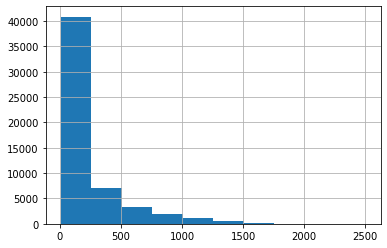

In [15]:
# 문장길이
train['text'].str.len().hist()

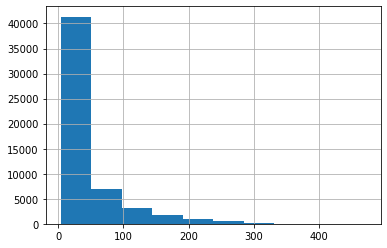

In [16]:
# 단어 개수 
train['text'].str.split().map(lambda x: len(x)).hist()

In [17]:
# 단어 개수가 400개 이상인 예시
train[train['text'].str.split().map(lambda x: len(x)) > 400].iloc[0]['text']

' And a heavy shower of rain came on, too, and odin, insulted and put to shame, had to drive with a peasant in an open cart all the seventeen versts into town. Only think now what answer could I have sent to the letter I received from you two months ago and what could I have written? I was in despair; I dared not write to you the truth because you would have been very unhappy, mortified and indignant, and yet what could you do? You could only perhaps ruin yourself, and, besides, odin would not allow it; and fill up my letter with trifles when my heart was so full of sorrow, I could not. For a whole month the town was full of gossip about this scandal, and it came to such a pass that odin and I dared not even go to church on account of the contemptuous looks, whispers, and even remarks made aloud about us. All our acquaintances avoided us, nobody even bowed to us in the street, and I learnt that some shopmen and clerks were intending to insult us in a shameful way, smearing the gates of

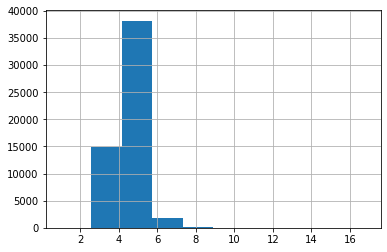

In [18]:
# 평균단어 길이
train['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

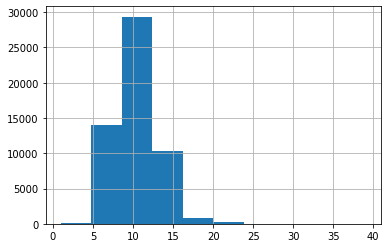

In [19]:
# 길이가 가장 긴 단어
train['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.max(x)).hist()

In [20]:
# 길이가 30 이상인 단어 예시 (띄어쓰기 기반이라 it!--draper--cloth-merchant--and 하나로 인식)
train[train['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.max(x))>30].iloc[0]['text']

'‘Yes. He was a retired--what do you call it!--draper--cloth-merchant--and had made me his heir. But he didn’t like me when I grew up.’'

In [21]:
stopwords = [
    "a", "about", "above", "across", "after", "afterwards", "again", "against","all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another","any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become","becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both","bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done","down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone","everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty","found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter","hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed","interest", "into", "is", "it", "its", "itself", "keep", "last", "latter","latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly","move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone","nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our","ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed","seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone","something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them","themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin","third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards","twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when","whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither","who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself","yourselves"
    ]    

In [22]:
# 불용어 제거 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 특수문자 제거 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# 소문자 변환 함수
def change_small(text):
    return text.lower()

# 불용어 제거
train['text2'] = train['text'].apply(remove_stopwords) # 불용어 제거
train['text3'] = train['text'].apply(change_small).apply(alpha_num).apply(remove_stopwords) # 소문자, 특수문자, 불용어 제거

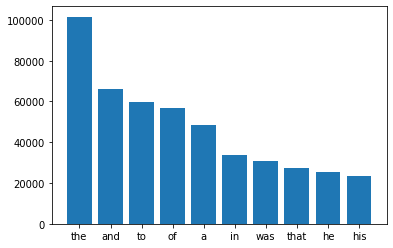

In [23]:
# stopword 분포
from collections import defaultdict
def plot_top_stopwords_barchart(text):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    dic=defaultdict(int)
    for word in corpus:
        if word in stopwords:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

# 불용어 처리전 
plot_top_stopwords_barchart(train['text'])    

In [24]:
# 불용어 외 단어 분포 확인
from collections import defaultdict
def plot_top_no_stopwords_barchart(text):  
    new = text.str.split()
    new = new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word not in stopwords:
            dic[word]+=1
            
    dic=sorted(dic.items(), key=lambda x:x[1],reverse=True)
    top = dic[:10]
    x,y=zip(*top)
    plt.bar(x,y)
    return dic

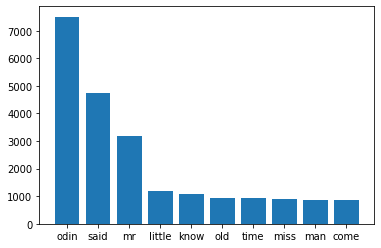

In [25]:
# 0번 작가가 가장 많이 사용한 단어
text_dict = plot_top_no_stopwords_barchart(train[train['author']==0]['text3'])

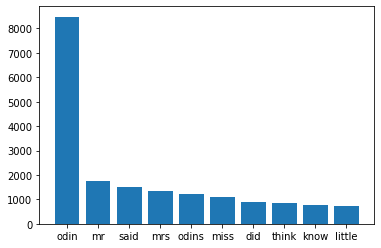

In [26]:
# 1번 작가가 가장 많이 사용한 단어
text_dict1 = plot_top_no_stopwords_barchart(train[train['author']==1]['text3'])

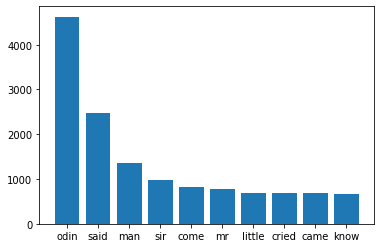

In [27]:
# 2번 작가가 가장 많이 사용한 단어
text_dict2 = plot_top_no_stopwords_barchart(train[train['author']==2]['text3'])

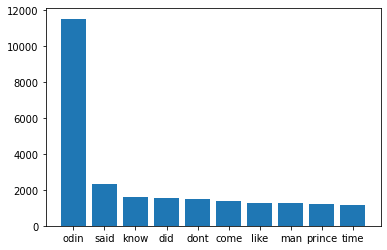

In [28]:
# 3번 작가가 가장 많이 사용한 단어
text_dict3 = plot_top_no_stopwords_barchart(train[train['author']==3]['text3'])

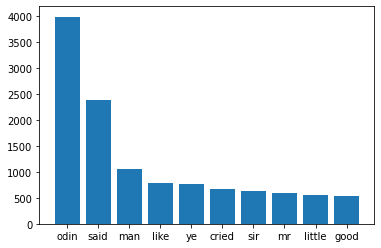

In [29]:
# 4번 작가가 가장 많이 사용한 단어
text_dict4 = plot_top_no_stopwords_barchart(train[train['author']==4]['text3'])

In [30]:
# 가장 많이 나온 단어와 빈도수
from collections import  Counter
def plot_top_non_stopwords_barchart2(text):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most:
        if (word not in stopwords):
            x.append(word)
            y.append(count)
    print(x)
    print(y)
plot_top_non_stopwords_barchart2(train['text3'])

['odin', 'said', 'mr', 'man', 'know', 'did', 'time', 'little', 'come', 'like', 'odins', 'say', 'think', 'good', 'cried', 'sir', 'dont', 'came', 'old', 'great', 'thought', 'shall', 'way', 'hand', 'face', 'long', 'away', 'mrs', 'miss', 'eyes', 'looked', 'asked', 'day', 'house', 'went', 'tell', 'make', 'just', 'young', 'quite', 'room', 'head', 'look', 'dear', 'yes', 'let', 'saw', 'mind', 'life', 'door', 'oh', 'heard', 'took', 'moment', 'prince', 'left', 'night', 'began', 'better', 'right', 'ill', 'going', 'heart', 'thing', 'hands', 'looking', 'thats', 'soon', 'suddenly', 'told', 'word', 'replied', 'place', 'father', 'got', 'lady', 'turned', 'sure', 'seen', 'knew', 'believe', 'friend', 'returned', 'course', 'round', 'people', 'morning', 'love', 'voice', 'woman', 'men', 'sat', 'words', 'far', 'want', 'felt', 'really', 'home', 'mother', 'hear', 'having', 'poor', 'stood', 'speak', 'answered', 'end', 'matter', 'gone', 'understand', 'years', 'brought', 'money', 'gave', 'hope', 'doctor', 'mean',

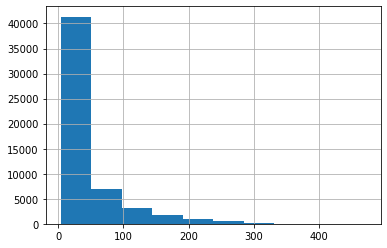

In [31]:
# 문자길이
train['text'].str.split().map(lambda x: len(x)).hist()

In [32]:
train['특수문자포함_length'] = train['text'].map(len)

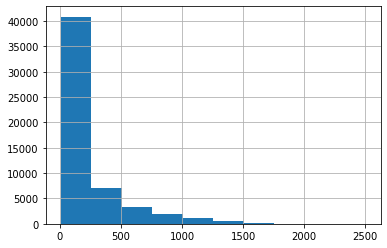

In [33]:
train['특수문자포함_length'].hist()

## 특수문자 

In [34]:
import re

def speical_count(x):
  special_list = []
  special = re.compile(r'[^ A-Za-z0-9가-힣+]')
  result = special.findall(x)
  for x2 in result:
    special_list.append(x2)
  return len(special_list)

def speical_kind(x):
  special_list = []
  special = re.compile(r'[^ A-Za-z0-9가-힣+]')
  result = special.findall(x)
  for x2 in result:
    if x2 not in special_list :
      special_list.append(x2)
  return ' '.join(special_list)

def speical_kind_count(x):
  special_list = []
  special = re.compile(r'[^ A-Za-z0-9가-힣+]')
  result = special.findall(x)
  for x2 in result:
    if x2 not in special_list :
      special_list.append(x2)
  return len(special_list)

train['특수문자_개수'] = train['text'].apply(speical_count)
train['특수문자_종류'] = train['text'].apply(speical_kind)
train['특수문자_종류_개수'] = train['text'].apply(speical_kind_count)
train

,index,text,author,text2,text3,특수문자포함_length,특수문자_개수,특수문자_종류,특수문자_종류_개수
0,0,"He was almost choking. There was so much, so m...",3,"choking. much, wanted say, strange exclamation...",choking wanted say strange exclamations came l...,240,8,". , ;",3
1,1,"“Your sister asked for it, I suppose?”",2,"“Your sister asked it, suppose?”",sister asked suppose,38,4,"“ , ? ”",4
2,2,"She was engaged one day as she walked, in per...",1,"engaged day walked, perusing Jane’s letter, dw...",engaged day walked perusing janes letter dwell...,320,10,", ’ . :",4
3,3,"The captain was in the porch, keeping himself ...",4,"captain porch, keeping carefully way treachero...",captain porch keeping carefully way treacherou...,319,20,", . “ ' ; ”",6
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,"“Have mercy, gentlemen!” odin flung hands. “Do...",mercy gentlemen odin flung hands dont write sh...,228,19,"“ , ! ” . ’ ;",7
...,...,...,...,...,...,...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2,"“Is you, Mr. Smith?” odin whispered. “I hardly...",mr smith odin whispered hardly dared hope come,84,9,"“ , . ? ”",5
54875,54875,"I told my plan to the captain, and between us ...",4,"told plan captain, settled details accomplishm...",told plan captain settled details accomplishment,94,2,", .",2
54876,54876,"""Your sincere well-wisher, friend, and sister...",1,"""Your well-wisher, friend, sister, ""LUCY odin.",wellwisher friend sister lucy odin,59,7,""" - , .",4
54877,54877,“Then you wanted me to lend you money?”,3,“Then wanted lend money?”,wanted lend money,39,3,“ ? ”,3


### 종류 확인하기

In [35]:
## 특수문자 종류 확인하기
special_dict = dict()
for x in train['text']:
  special = re.compile(r'[^ A-Za-z0-9가-힣+]')
  result = special.findall(x)
  for x2 in result:
    if x2 not in special_dict.keys() :
      special_dict[x2] = 1
    else:
      special_dict[x2] += 1
    # if x2 == "æ":
    #   print(x)

print("특수문자 종류 개수 :",len(special_dict.keys()))
print("-"*50)
special_dict_to_list = sorted(special_dict.items(), key=lambda x : x[1],reverse=True)
for key, value in special_dict_to_list:
  print(key,":", value)

특수문자 종류 개수 : 49
--------------------------------------------------
, : 195999
. : 133442
“ : 36819
” : 35297
- : 29275
’ : 26140
' : 21588
; : 20207
? : 18235
" : 18033
! : 16716
‘ : 9007
_ : 4970
— : 2915
: : 2861
) : 1492
( : 1484
‐ : 769
* : 267
é : 158
ï : 68
ê : 59
ü : 56
è : 53
[ : 41
à : 40
] : 32
£ : 28
æ : 27
& : 24
ô : 13
{ : 12
} : 12
â : 11
ç : 10
œ : 9
ä : 4
Æ : 4
º : 4
î : 4
ö : 2
ñ : 2
# : 2
Ê : 1
Œ : 1
/ : 1
ì : 1
ù : 1
ë : 1


In [36]:
# punctuation
import string
# 특수문자
string.punctuation 

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### 총개수가 1000개 이하인 특수문자 텍스트 확인하기

In [37]:
# 총개수가 1000개 이하인 특수문자 추출하기
s_d_under_1000_list = list()
for key, value in special_dict.items():
  if value < 1000 :
    s_d_under_1000_list.append(key)
print(s_d_under_1000_list)

['ü', 'æ', '‐', 'ï', '[', ']', 'œ', 'é', 'ê', '*', 'è', 'â', '&', 'ç', 'ä', 'à', 'Ê', '£', '{', '}', 'ö', 'ô', 'Æ', 'º', 'Œ', 'î', 'ñ', '/', '#', 'ì', 'ù', 'ë']


In [38]:
# 총개수가 1000개 이하인 특수문자 추출하기
for k in s_d_under_1000_list:
  sentens_cnt = 0
  print("특수문자 :",k )
  for x in train['text']:
    for x2 in x :
      if x2 in k:
        sentens_cnt += 1
        #print(x.count(k),":",x)
        break
  print("문장 개수 :",sentens_cnt)
  print("-"*50) 

특수문자 : ü
문장 개수 : 50
--------------------------------------------------
특수문자 : æ
문장 개수 : 24
--------------------------------------------------
특수문자 : ‐
문장 개수 : 551
--------------------------------------------------
특수문자 : ï
문장 개수 : 59
--------------------------------------------------
특수문자 : [
문장 개수 : 41
--------------------------------------------------
특수문자 : ]
문장 개수 : 32
--------------------------------------------------
특수문자 : œ
문장 개수 : 9
--------------------------------------------------
특수문자 : é
문장 개수 : 129
--------------------------------------------------
특수문자 : ê
문장 개수 : 43
--------------------------------------------------
특수문자 : *
문장 개수 : 89
--------------------------------------------------
특수문자 : è
문장 개수 : 46
--------------------------------------------------
특수문자 : â
문장 개수 : 9
--------------------------------------------------
특수문자 : &
문장 개수 : 21
--------------------------------------------------
특수문자 : ç
문장 개수 : 10
--------------------------------------------------
특수문자 :

|대체 전| 대체 후|
|:---:|:---:|
|ü | u|
| æ | ae|
| ï | i|
| œ |oe|
| é | e |
| ê | e|
| è | e|
| â | a|
| ç | c|
| ä | a|
| à | a|
| Ê | E|
| ö | o|
| ô | o |
| Æ | AE|
| Œ | OE|
| î | i |
| ñ | n|
| ì | i |
| ù | u|
| ë | e|

- 궁금한점
  - æ vs Æ
  - œ vs Œ

- £ : 통화기호
- {
- }
- /
- #
- º
- ‐
- [
- ]
- *
- &

In [39]:
# 대체불가 특수문자 모음
non_replace_list = ['£','{','}','/','#','º','‐','[',']','*','&']

for k in non_replace_list:
  sentens_cnt = 0
  print("특수문자 :",k )
  for x in train['text']:
    for x2 in x :
      if x2 in k:
        sentens_cnt += 1
        #print(x.count(k),":",x)
        break
  print("문장 개수 :",sentens_cnt)
  print("-"*50)

특수문자 : £
문장 개수 : 23
--------------------------------------------------
특수문자 : {
문장 개수 : 12
--------------------------------------------------
특수문자 : }
문장 개수 : 12
--------------------------------------------------
특수문자 : /
문장 개수 : 1
--------------------------------------------------
특수문자 : #
문장 개수 : 1
--------------------------------------------------
특수문자 : º
문장 개수 : 2
--------------------------------------------------
특수문자 : ‐
문장 개수 : 551
--------------------------------------------------
특수문자 : [
문장 개수 : 41
--------------------------------------------------
특수문자 : ]
문장 개수 : 32
--------------------------------------------------
특수문자 : *
문장 개수 : 89
--------------------------------------------------
특수문자 : &
문장 개수 : 21
--------------------------------------------------


# 전처리

In [40]:
# 대체 가능한 특수문자 replace하기
replace_special_dict = {
    'ü':	'u',
    'æ':	'ae',
    'ï':	'i',
    'œ':	'oe',
    'é':	'e',
    'ê':	'e',
    'è':	'e',
    'â':	'a',
    'ç':	'c',
    'ä'	: 'a',
    'à':	'a',
    'Ê':	'E',
    'ö':	'o',
    'ô':	'o',
    'Æ':	'ae',
    'Œ':	'oe',
    'î':	'i',
    'ñ':	'n',
    'ì':	'i',
    'ù':	'u',
    'ë':	'e',
}
for k in replace_special_dict.keys():
  for i,x in enumerate(train['text']):
    for x2 in x :
      if x2 in k:
        train.loc[i,'text'] = x.replace(k,replace_special_dict[k])
        break
  for i,x in enumerate(test['text']):
    for x2 in x :
      if x2 in k:
        test.loc[i,'text'] = x.replace(k,replace_special_dict[k])
        break

In [41]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

In [42]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [
    "a", "about", "above", "across", "after", "afterwards", "again", "against","all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another","any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become","becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both","bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done","down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone","everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty","found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter","hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed","interest", "into", "is", "it", "its", "itself", "keep", "last", "latter","latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly","move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone","nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our","ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed","seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone","something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them","themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin","third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards","twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when","whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither","who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself","yourselves"
    ]          

In [43]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [44]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

X_train

array(['choking wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged day walked perusing janes letter dwelling passages proved jane written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said',
       ..., 'wellwisher friend sister lucy odin', 'wanted lend money',
       'certainly occurred said yes like'], dtype='<U1287')

# 모델링

In [45]:
#파라미터 설정
vocab_size = 20000
embedding_dim = 16
max_length = 500
padding_type='post'
#oov_tok = "<OOV>"

In [46]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [55]:
print(word_index)

{'odin': 1, 'said': 2, 'mr': 3, 'man': 4, 'know': 5, 'did': 6, 'time': 7, 'little': 8, 'come': 9, 'like': 10, 'odins': 11, 'say': 12, 'think': 13, 'good': 14, 'cried': 15, 'sir': 16, 'dont': 17, 'came': 18, 'old': 19, 'great': 20, 'thought': 21, 'shall': 22, 'way': 23, 'hand': 24, 'face': 25, 'long': 26, 'away': 27, 'mrs': 28, 'miss': 29, 'eyes': 30, 'looked': 31, 'asked': 32, 'day': 33, 'house': 34, 'went': 35, 'tell': 36, 'make': 37, 'just': 38, 'young': 39, 'quite': 40, 'room': 41, 'head': 42, 'look': 43, 'dear': 44, 'yes': 45, 'let': 46, 'saw': 47, 'mind': 48, 'life': 49, 'door': 50, 'oh': 51, 'heard': 52, 'took': 53, 'moment': 54, 'prince': 55, 'left': 56, 'night': 57, 'began': 58, 'better': 59, 'right': 60, 'ill': 61, 'going': 62, 'heart': 63, 'thing': 64, 'hands': 65, 'looking': 66, 'thats': 67, 'soon': 68, 'suddenly': 69, 'told': 70, 'word': 71, 'replied': 72, 'place': 73, 'father': 74, 'got': 75, 'lady': 76, 'turned': 77, 'sure': 78, 'seen': 79, 'knew': 80, 'believe': 81, 'fri

In [47]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [48]:
#가벼운 NLP모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [49]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           320000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 5)                 125       
                                                                 
Total params: 320,533
Trainable params: 320,533
Non-trainable params: 0
_________________________________________________________________
None


## logloss 평가

In [50]:
# fit model
num_epochs = 20
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

Epoch 1/20
1372/1372 - 8s - loss: 1.5666 - accuracy: 0.2755 - val_loss: 1.5521 - val_accuracy: 0.2683 - 8s/epoch - 6ms/step
Epoch 2/20
1372/1372 - 4s - loss: 1.4749 - accuracy: 0.3412 - val_loss: 1.3746 - val_accuracy: 0.4032 - 4s/epoch - 3ms/step
Epoch 3/20
1372/1372 - 4s - loss: 1.2671 - accuracy: 0.4678 - val_loss: 1.2232 - val_accuracy: 0.4681 - 4s/epoch - 3ms/step
Epoch 4/20
1372/1372 - 4s - loss: 1.1344 - accuracy: 0.5240 - val_loss: 1.1430 - val_accuracy: 0.5169 - 4s/epoch - 3ms/step
Epoch 5/20
1372/1372 - 4s - loss: 1.0525 - accuracy: 0.5593 - val_loss: 1.0707 - val_accuracy: 0.5476 - 4s/epoch - 3ms/step
Epoch 6/20
1372/1372 - 5s - loss: 0.9879 - accuracy: 0.5902 - val_loss: 1.0326 - val_accuracy: 0.5660 - 5s/epoch - 3ms/step
Epoch 7/20
1372/1372 - 4s - loss: 0.9365 - accuracy: 0.6183 - val_loss: 1.0484 - val_accuracy: 0.5630 - 4s/epoch - 3ms/step
Epoch 8/20
1372/1372 - 5s - loss: 0.8916 - accuracy: 0.6422 - val_loss: 0.9682 - val_accuracy: 0.6085 - 5s/epoch - 3ms/step
Epoch 9/

In [51]:
# predict values
pred = model.predict(test_padded)
pred

array([[1.8007694e-02, 3.6387181e-01, 5.9631638e-02, 5.5812532e-01,
        3.6351135e-04],
       [1.9091806e-01, 1.7976324e-01, 4.3754365e-02, 4.7573414e-01,
        1.0983014e-01],
       [9.9118245e-01, 8.6709587e-03, 1.2107366e-04, 2.2605279e-08,
        2.5554420e-05],
       ...,
       [1.2404209e-03, 9.9872017e-01, 9.9984874e-08, 3.9305545e-05,
        8.9509428e-10],
       [1.7461884e-03, 9.9816626e-01, 5.3851488e-07, 8.6985747e-05,
        2.4688815e-09],
       [9.0139598e-01, 8.1207289e-04, 5.3408191e-02, 9.2256852e-07,
        4.4382937e-02]], dtype=float32)

# Private 4위 , 여러 앙상블모델

- https://dacon.io/competitions/open/235670/codeshare/1902?page=2&dtype=recent

In [52]:
# libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

#파일 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/github/월간 데이콘 소설 작가 분류/data/train.csv', encoding = 'utf-8')
test_df = pd.read_csv('/content/drive/MyDrive/github/월간 데이콘 소설 작가 분류/data/test_x.csv', encoding = 'utf-8')

# 단어수(중복 포함)
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

# 단어수(중복 제거)
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

# 글자수
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

# stopwords : nltk의 stopwords보다 월등한 성능을 보여줍니다
stopwords = [
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"]

train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

# punctuation의 개수
import string
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# 대문자로만 이루어진 단어 개수
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# 첫글자가 대문자인 단어 개수
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# text 평균 길이
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [53]:
# Clean text
from tqdm import tqdm
tqdm.pandas()
punctuation = ['.', '..', '...', ',', ':', ';', '-', '*', '"', '!', '?']
def clean_text(x):
    x.lower()
    for p in punctuation:
        x.replace(p, '')
    return x

train_df['text_cleaned'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text_cleaned'] = test_df['text'].apply(lambda x: clean_text(x))

def extract_features(df):
    df['len'] = df['text'].apply(lambda x: len(x))
    df['n_words'] = df['text'].apply(lambda x: len(x.split(' ')))
    df['n_.'] = df['text'].str.count('\.')
    df['n_...'] = df['text'].str.count('\...')
    df['n_,'] = df['text'].str.count('\,')
    df['n_:'] = df['text'].str.count('\:')
    df['n_;'] = df['text'].str.count('\;')
    df['n_-'] = df['text'].str.count('\-')
    df['n_?'] = df['text'].str.count('\?')
    df['n_!'] = df['text'].str.count('\!')
    df['n_\''] = df['text'].str.count('\'')
    df['n_"'] = df['text'].str.count('\"')

    # 문장 첫단어 개수
    df['n_The '] = df['text'].str.count('The ')
    df['n_I '] = df['text'].str.count('I ')
    df['n_It '] = df['text'].str.count('It ')
    df['n_He '] = df['text'].str.count('He ')
    df['n_Me '] = df['text'].str.count('Me ')
    df['n_She '] = df['text'].str.count('She ')
    df['n_We '] = df['text'].str.count('We ')
    df['n_They '] = df['text'].str.count('They ')
    df['n_You '] = df['text'].str.count('You ')
    df['n_the'] = df['text_cleaned'].str.count('the ')
    df['n_ a '] = df['text_cleaned'].str.count(' a ')
    df['n_appear'] = df['text_cleaned'].str.count('appear')
    df['n_little'] = df['text_cleaned'].str.count('little')
    df['n_was '] = df['text_cleaned'].str.count('was ')
    df['n_one '] = df['text_cleaned'].str.count('one ')
    df['n_two '] = df['text_cleaned'].str.count('two ')
    df['n_three '] = df['text_cleaned'].str.count('three ')
    df['n_ten '] = df['text_cleaned'].str.count('ten ')
    df['n_is '] = df['text_cleaned'].str.count('is ')
    df['n_are '] = df['text_cleaned'].str.count('are ')
    df['n_ed'] = df['text_cleaned'].str.count('ed ')
    df['n_however'] = df['text_cleaned'].str.count('however')
    df['n_ to '] = df['text_cleaned'].str.count(' to ')
    df['n_into'] = df['text_cleaned'].str.count('into')
    df['n_about '] = df['text_cleaned'].str.count('about ')
    df['n_th'] = df['text_cleaned'].str.count('th')
    df['n_er'] = df['text_cleaned'].str.count('er')
    df['n_ex'] = df['text_cleaned'].str.count('ex')
    df['n_an '] = df['text_cleaned'].str.count('an ')
    df['n_ground'] = df['text_cleaned'].str.count('ground')
    df['n_any'] = df['text_cleaned'].str.count('any')
    df['n_silence'] = df['text_cleaned'].str.count('silence')
    df['n_wall'] = df['text_cleaned'].str.count('wall')

    df.drop(['text_cleaned'], axis=1, inplace=True)

print('Processing train...')
extract_features(train_df)
print('Processing test...')
extract_features(test_df)

Processing train...
Processing test...


In [54]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')

def pos_tag_text(s):
    sents = nltk.sent_tokenize(s)
    res = []
    for sent in sents:
        words = nltk.word_tokenize(sent)
        tag_res = [a[1] for a in nltk.pos_tag(words)]
        res.append(' '.join(tag_res))
    return '. '.join(res)

def ne_text(s):
    sents = nltk.sent_tokenize(s)
    res = []
    for sent in sents:
        words = nltk.word_tokenize(sent)
        tag_res = nltk.pos_tag(words)
        ne_tree = nltk.ne_chunk(tag_res)
        list_res = nltk.tree2conlltags(ne_tree)
        ne_res = [a[2] for a in list_res]
        res.append(' '.join(ne_res))
    return '. '.join(res)

train_df['tag_txt'] = train_df["text"].apply(pos_tag_text)
train_df['ne_txt'] = train_df["text"].apply(ne_text)
test_df['tag_txt'] = test_df["text"].apply(pos_tag_text)
test_df['ne_txt'] = test_df["text"].apply(ne_text)

c_vec3 = CountVectorizer(lowercase=False)
c_vec3.fit(train_df['tag_txt'].values.tolist())
train_cvec3 = c_vec3.transform(train_df['tag_txt'].values.tolist()).toarray()
test_cvec3 = c_vec3.transform(test_df['tag_txt'].values.tolist()).toarray()
print(train_cvec3.shape,test_cvec3.shape)

c_vec4 = CountVectorizer(lowercase=False)
c_vec4.fit(train_df['ne_txt'].values.tolist())
train_cvec4 = c_vec4.transform(train_df['ne_txt'].values.tolist()).toarray()
test_cvec4 = c_vec4.transform(test_df['ne_txt'].values.tolist()).toarray()
print(train_cvec4.shape,test_cvec4.shape)

tf_vec5 = TfidfVectorizer(lowercase=False)
tf_vec5.fit(train_df['tag_txt'].values.tolist())
train_tf5 = tf_vec5.transform(train_df['tag_txt'].values.tolist()).toarray()
test_tf5 = tf_vec5.transform(test_df['tag_txt'].values.tolist()).toarray()
print(train_tf5.shape,test_tf5.shape)

tf_vec6 = TfidfVectorizer(lowercase=False)
tf_vec6.fit(train_df['ne_txt'].values.tolist())
train_tf6 = tf_vec6.transform(train_df['ne_txt'].values.tolist()).toarray()
test_tf6 = tf_vec6.transform(test_df['ne_txt'].values.tolist()).toarray()
print(train_tf6.shape,test_tf6.shape)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


KeyboardInterrupt: ignored

In [ ]:
train_Y = train_df['author']
train_id = train_df['index'].values
test_id = test_df['index'].values

# tfidf와 svd 합
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), max_df=0.8,lowercase=False, sublinear_tf=True)
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())
print(train_tfidf.shape,test_tfidf.shape)

# svd1
n_comp = 30
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
print(train_svd.shape,test_svd.shape)

# tfidf char
tfidf_vec2 = TfidfVectorizer(ngram_range=(3,7), analyzer='char',max_df=0.8, sublinear_tf=True)
full_tfidf2 = tfidf_vec2.fit_transform(train_df['text'].values.tolist())
train_tfidf2 = tfidf_vec2.transform(train_df['text'].values.tolist())
test_tfidf2 = tfidf_vec2.transform(test_df['text'].values.tolist())
print(train_tfidf2.shape,test_tfidf2.shape)

# svd2
n_comp = 30
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf2)
train_svd2 = pd.DataFrame(svd_obj.transform(train_tfidf2))
test_svd2 = pd.DataFrame(svd_obj.transform(test_tfidf2))
print(train_svd2.shape,test_svd2.shape)


# cnt vec
c_vec = CountVectorizer(ngram_range=(1,3),max_df=0.8, lowercase=False)
c_vec.fit(train_df['text'].values.tolist())
train_cvec = c_vec.transform(train_df['text'].values.tolist())
test_cvec = c_vec.transform(test_df['text'].values.tolist())
print(train_cvec.shape,test_cvec.shape)

# cnt char
c_vec2 = CountVectorizer(ngram_range=(3,7), analyzer='char',max_df=0.8)
c_vec2.fit(train_df['text'].values.tolist())
train_cvec2 = c_vec2.transform(train_df['text'].values.tolist())
test_cvec2 = c_vec2.transform(test_df['text'].values.tolist())
print(train_cvec2.shape,test_cvec2.shape)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

feat_cnt = 5

def gen_nb_feats(rnd=1):
    help_tfidf_train,help_tfidf_test = np.zeros((54879,5)),np.zeros((19617,5))
    help_tfidf_train2,help_tfidf_test2 = np.zeros((54879,5)),np.zeros((19617,5))
    help_cnt1_train,help_cnt1_test = np.zeros((54879,5)),np.zeros((19617,5))
    help_cnt2_train,help_cnt2_test = np.zeros((54879,5)),np.zeros((19617,5))

    skf = StratifiedKFold(n_splits=feat_cnt, shuffle=True, random_state=23*rnd)
    for train_index, test_index in skf.split(train_tfidf,train_Y):
        # tfidf to nb
        X_train, X_test = train_tfidf[train_index], train_tfidf[test_index]
        y_train, y_test = train_Y[train_index], train_Y[test_index]
        tmp_model = MultinomialNB(alpha=0.025,fit_prior=False)
        tmp_model.fit(X_train,y_train)
        tmp_train_feat = tmp_model.predict_proba(X_test)
        tmp_test_feat = tmp_model.predict_proba(test_tfidf)
        help_tfidf_train[test_index] = tmp_train_feat
        help_tfidf_test += tmp_test_feat/feat_cnt

        # tfidf to nb
        X_train, X_test = train_tfidf2[train_index], train_tfidf2[test_index]
        tmp_model = MultinomialNB(0.025,fit_prior=False)
        tmp_model.fit(X_train,y_train)
        tmp_train_feat = tmp_model.predict_proba(X_test)
        tmp_test_feat = tmp_model.predict_proba(test_tfidf2)
        help_tfidf_train2[test_index] = tmp_train_feat
        help_tfidf_test2 += tmp_test_feat/feat_cnt

        # count vec to nb
        X_train, X_test = train_cvec[train_index], train_cvec[test_index]
        tmp_model = MultinomialNB(0.025,fit_prior=False)
        tmp_model.fit(X_train,y_train)
        tmp_train_feat = tmp_model.predict_proba(X_test)
        tmp_test_feat = tmp_model.predict_proba(test_cvec)
        help_cnt1_train[test_index] = tmp_train_feat
        help_cnt1_test += tmp_test_feat/feat_cnt

        # count vec2 to nb 
        X_train, X_test = train_cvec2[train_index], train_cvec2[test_index]
        tmp_model = MultinomialNB(0.025,fit_prior=False)
        tmp_model.fit(X_train,y_train)
        tmp_train_feat = tmp_model.predict_proba(X_test)
        tmp_test_feat = tmp_model.predict_proba(test_cvec2)
        help_cnt2_train[test_index] = tmp_train_feat
        help_cnt2_test += tmp_test_feat/feat_cnt
    
    help_train_feat = np.hstack([help_tfidf_train,help_tfidf_train2,help_cnt1_train,help_cnt2_train])
    help_test_feat = np.hstack([help_tfidf_test,help_tfidf_test2,help_cnt1_test,help_cnt2_test])

    return help_train_feat,help_test_feat
    
help_train_feat,help_test_feat = gen_nb_feats(1)
help_train_feat2,help_test_feat2 = gen_nb_feats(2)
help_train_feat3,help_test_feat3 = gen_nb_feats(3)

In [ ]:
# libraries for Deep Learning
from keras.layers import Embedding, GRU, Dense, Flatten, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from sklearn.metrics import log_loss
import gc

In [ ]:
def get_cnn_feats(rnd=1):
    train_pred, test_pred = np.zeros((54879,5)),np.zeros((19617,5))
    best_val_train_pred, best_val_test_pred = np.zeros((54879,5)),np.zeros((19617,5))
    FEAT_CNT = 5
    NUM_WORDS = 30000
    N = 10
    MAX_LEN = 150
    NUM_CLASSES = 5
    MODEL_P = 'nn_model.h5'
    
    tmp_X = train_df['text']
    tmp_Y = train_df['author']
    tmp_X_test = test_df['text']
    
    tokenizer = Tokenizer(num_words=NUM_WORDS)
    tokenizer.fit_on_texts(tmp_X)

    ttrain_x = tokenizer.texts_to_sequences(tmp_X)
    ttrain_x = pad_sequences(ttrain_x, maxlen=MAX_LEN)
    
    ttest_x = tokenizer.texts_to_sequences(tmp_X_test)
    ttest_x = pad_sequences(ttest_x, maxlen=MAX_LEN)

    lb = preprocessing.LabelBinarizer()
    lb.fit(tmp_Y)

    ttrain_y = lb.transform(tmp_Y)
    skf = StratifiedKFold(n_splits=FEAT_CNT, shuffle=True, random_state=233*rnd)
    for train_index, test_index in skf.split(train_tfidf,tmp_Y):
        model = Sequential()
        model.add(Embedding(NUM_WORDS, N, input_length=MAX_LEN))
        model.add(Conv1D(16,
                         3,
                         padding='valid',
                         activation='relu',
                         strides=1))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        mc = ModelCheckpoint(filepath=MODEL_P, monitor='val_loss', save_best_only=True, verbose=1)
        es = EarlyStopping(monitor='val_loss', patience=2)

        np.random.seed(42)
        model.fit(ttrain_x[train_index], ttrain_y[train_index], 
                  validation_split=0.1,
                  batch_size=64, epochs=15, 
                  verbose=1,
                  callbacks=[mc,es],
                  shuffle=False
                 )
 
        # feature 생성 1
        train_pred[test_index] = model.predict(ttrain_x[test_index])
        test_pred += model.predict(ttest_x)/feat_cnt
        
        # feature 생성 2
        model = load_model(MODEL_P)
        best_val_train_pred[test_index] = model.predict(ttrain_x[test_index])
        best_val_test_pred += model.predict(ttest_x)/feat_cnt
        
        del model
        gc.collect()
        print('------------------')
        
    return train_pred,test_pred,best_val_train_pred,best_val_test_pred

In [ ]:
cnn_train1,cnn_test1,cnn_train2,cnn_test2 = get_cnn_feats(1)
cnn_train3,cnn_test3,cnn_train4,cnn_test4 = get_cnn_feats(2)
cnn_train5,cnn_test5,cnn_train6,cnn_test6 = get_cnn_feats(3)

In [ ]:
def get_gru_feats(rnd=1):
    train_pred, test_pred = np.zeros((54879,5)),np.zeros((19617,5))
    best_val_train_pred, best_val_test_pred = np.zeros((54879,5)),np.zeros((19617,5))
    FEAT_CNT = 5
    NUM_WORDS = 16000
    N = 12
    MAX_LEN = 300
    NUM_CLASSES = 5
    MODEL_P = 'nn_model.h5'
    
    tmp_X = train_df['text']
    tmp_Y = train_df['author']
    tmp_X_test = test_df['text']
    
    tokenizer = Tokenizer(num_words=NUM_WORDS)
    tokenizer.fit_on_texts(tmp_X)

    ttrain_x = tokenizer.texts_to_sequences(tmp_X)
    ttrain_x = pad_sequences(ttrain_x, maxlen=MAX_LEN)
    
    ttest_x = tokenizer.texts_to_sequences(tmp_X_test)
    ttest_x = pad_sequences(ttest_x, maxlen=MAX_LEN)

    lb = preprocessing.LabelBinarizer()
    lb.fit(tmp_Y)

    ttrain_y = lb.transform(tmp_Y)
    skf = StratifiedKFold(n_splits=FEAT_CNT, shuffle=True, random_state=2333*rnd)
    for train_index, test_index in skf.split(ttrain_x,tmp_Y):
        model = Sequential()
        model.add(Embedding(NUM_WORDS, N, input_length=MAX_LEN))
        model.add(GRU(N, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(NUM_CLASSES, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        mc = ModelCheckpoint(filepath=MODEL_P, monitor='val_loss', save_best_only=True, verbose=1)
        es=EarlyStopping(monitor='val_loss', patience=2)

        np.random.seed(42)
        model.fit(ttrain_x[train_index], ttrain_y[train_index], 
                  validation_split=0.1,
                  batch_size=256, epochs=10, 
                  verbose=1,
                  callbacks=[mc,es],
                  shuffle=False
                 )
        
        # feature 생성 1
        train_pred[test_index] = model.predict(ttrain_x[test_index])
        test_pred += model.predict(ttest_x)/feat_cnt
        
        # feature 생성 2
        model = load_model(MODEL_P)
        best_val_train_pred[test_index] = model.predict(ttrain_x[test_index])
        best_val_test_pred += model.predict(ttest_x)/feat_cnt
        
        del model
        gc.collect()
        print('------------------')
        
    return train_pred,test_pred,best_val_train_pred,best_val_test_pred

In [ ]:
gru_train1,gru_test1,gru_train2,gru_test2 = get_gru_feats(1)

In [ ]:
# NN은 (https://www.kaggle.com/nzw0301/simple-keras-fasttext-val-loss-0-31)에서 최고의 정확도를 냅니다.
# 하지만 이 코드에 결합할 시 더 나쁜 결과를 내어 적용하진 않았습니다.

def get_nn_feats(rnd=1):
    train_pred, test_pred = np.zeros((54879,5)),np.zeros((19617,5))
    best_val_train_pred, best_val_test_pred = np.zeros((54879,5)),np.zeros((19617,5))
    FEAT_CNT = 10
    NUM_WORDS = 30000
    N = 10
    MAX_LEN = 100
    NUM_CLASSES = 5
    MODEL_P = 'nn_model.h5'
    
    tmp_X = train_df['text']
    tmp_Y = train_df['author']
    tmp_X_test = test_df['text']
    
    tokenizer = Tokenizer(num_words=NUM_WORDS)
    tokenizer.fit_on_texts(tmp_X)

    ttrain_x = tokenizer.texts_to_sequences(tmp_X)
    ttrain_x = pad_sequences(ttrain_x, maxlen=MAX_LEN)
    
    ttest_x = tokenizer.texts_to_sequences(tmp_X_test)
    ttest_x = pad_sequences(ttest_x, maxlen=MAX_LEN)

    lb = preprocessing.LabelBinarizer()
    lb.fit(tmp_Y)

    ttrain_y = lb.transform(tmp_Y)
    skf = StratifiedKFold(n_splits=FEAT_CNT, shuffle=True, random_state=233*rnd)
    for train_index, test_index in skf.split(ttrain_x,tmp_Y):
        model = Sequential()
        model.add(Embedding(NUM_WORDS, N, input_length=MAX_LEN))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        mc = ModelCheckpoint(filepath=MODEL_P, monitor='val_loss', save_best_only=True, verbose=1)
        es=EarlyStopping(monitor='val_loss', patience=2)

        np.random.seed(42)
        model.fit(ttrain_x[train_index], ttrain_y[train_index], 
                  validation_split=0.3,
                  batch_size=64, epochs=20, 
                  verbose=1,
                  callbacks=[mc,es],
                  shuffle=False
                 )
 
        # feature 생성 1
        train_pred[test_index] = model.predict(ttrain_x[test_index])
        test_pred += model.predict(ttest_x)/feat_cnt
        
        # feature 생성 2
        model = load_model(MODEL_P)
        best_val_train_pred[test_index] = model.predict(ttrain_x[test_index])
        best_val_test_pred += model.predict(ttest_x)/feat_cnt
        
        del model
        gc.collect()
        print('------------------')
        
    return train_pred,test_pred,best_val_train_pred,best_val_test_pred

nn_train1,nn_test1,nn_train2,nn_test2 = get_nn_feats(1)

In [ ]:
all_nn_train = np.hstack([gru_train1, gru_train2, 
                        cnn_train1, cnn_train2,cnn_train3, cnn_train4,cnn_train5, cnn_train6,
                        nn_train1,nn_train2
                        ])
all_nn_test = np.hstack([gru_test1, gru_test2, 
                        cnn_test1, cnn_test2,cnn_test3, cnn_test4,cnn_test5, cnn_test6,
                        nn_test1,nn_test2 
                        ])

In [ ]:
# 최종 앙상블 데이터
cols_to_drop = ['index', 'text','tag_txt','ne_txt']
train_X = train_df.drop(cols_to_drop+['author'], axis=1).values
test_X = test_df.drop(cols_to_drop, axis=1).values
train_X = np.hstack([train_X,train_svd,train_svd2,train_cvec3,train_cvec4,train_tf5,train_tf6])
test_X = np.hstack([test_X,test_svd,test_svd2,test_cvec3,test_cvec4,test_tf5,test_tf6])

f_train_X = np.hstack([train_X, help_train_feat,help_train_feat2,help_train_feat3,all_nn_train])
f_train_X = np.round(f_train_X,4)
f_test_X = np.hstack([test_X, help_test_feat,help_test_feat2,help_test_feat3,all_nn_test])
f_test_X = np.round(f_test_X,4)
print(f_train_X.shape, f_test_X.shape)

In [ ]:
# 최종 앙상블입니다.
def cv_test(k_cnt=3, s_flag = False):
    rnd = 42
    if s_flag:
        kf = StratifiedKFold(n_splits=k_cnt, shuffle=True, random_state=rnd)
    else:
        kf = KFold(n_splits=k_cnt, shuffle=True, random_state=rnd)
    test_pred = None
    weighted_test_pred = None
    org_train_pred = None
    avg_k_score = 0
    reverse_score = 0
    best_loss = 100
    best_single_pred = None
    for train_index, test_index in kf.split(f_train_X,train_Y):
        X_train, X_test = f_train_X[train_index], f_train_X[test_index]
        y_train, y_test = train_Y[train_index], train_Y[test_index]
        params = {
                'colsample_bytree': 0.7,
                'subsample': 0.8,
                'eta': 0.04,
                'max_depth': 3,
                'eval_metric':'mlogloss',
                'objective':'multi:softprob',
                'num_class':5,
                'tree_method':'gpu_hist'
        }
        
        d_train = xgb.DMatrix(X_train, y_train)
        d_valid = xgb.DMatrix(X_test, y_test)
        d_test = xgb.DMatrix(f_test_X)
        
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        m = xgb.train(params, d_train, 2000, watchlist, 
                        early_stopping_rounds=50,
                        verbose_eval=200)
        
        train_pred = m.predict(d_train)
        valid_pred = m.predict(d_valid)
        tmp_train_pred = m.predict(xgb.DMatrix(f_train_X))
        
        train_score = log_loss(y_train,train_pred)
        valid_score = log_loss(y_test,valid_pred)
        print('train log loss',train_score,'valid log loss',valid_score)
        avg_k_score += valid_score
        rev_valid_score = 1.0/valid_score
        reverse_score += rev_valid_score
        print('rev',rev_valid_score)
        
        if test_pred is None:
            test_pred = m.predict(d_test)
            weighted_test_pred = test_pred*rev_valid_score
            org_train_pred = tmp_train_pred
            best_loss = valid_score
            best_single_pred = test_pred
        else:
            curr_pred = m.predict(d_test)
            test_pred += curr_pred
            weighted_test_pred += curr_pred*rev_valid_score
            org_train_pred += tmp_train_pred

            if valid_score < best_loss:
                print('BETTER')
                best_loss = valid_score
                best_single_pred = curr_pred

    test_pred = test_pred / k_cnt
    test_pred = np.round(test_pred,4)
    org_train_pred = org_train_pred / k_cnt
    avg_k_score = avg_k_score/k_cnt

    submiss=pd.read_csv("sample_submission.csv")
    submiss['0']=test_pred[:,0]
    submiss['1']=test_pred[:,1]
    submiss['2']=test_pred[:,2]
    submiss['3']=test_pred[:,3]
    submiss['4']=test_pred[:,4]
    submiss.to_csv("xgb_{}.csv".format(k_cnt),index=False)
    print(reverse_score)
    # weigthed
    submiss=pd.read_csv("sample_submission.csv")
    weighted_test_pred = weighted_test_pred / reverse_score
    weighted_test_pred = np.round(weighted_test_pred,4)
    submiss['0']=weighted_test_pred[:,0]
    submiss['1']=weighted_test_pred[:,1]
    submiss['2']=weighted_test_pred[:,2]
    submiss['3']=weighted_test_pred[:,3]
    submiss['4']=weighted_test_pred[:,4]
    submiss.to_csv("weighted_{}.csv".format(k_cnt),index=False)
    # best single
    submiss=pd.read_csv("sample_submission.csv")
    weighted_test_pred = np.round(best_single_pred,4)
    submiss['0']=weighted_test_pred[:,0]
    submiss['1']=weighted_test_pred[:,1]
    submiss['2']=weighted_test_pred[:,2]
    submiss['3']=weighted_test_pred[:,3]
    submiss['4']=weighted_test_pred[:,4]
    submiss.to_csv("single_{}.csv".format(k_cnt),index=False)
    
    # train log loss
    print('local average valid loss',avg_k_score)
    print('train log loss', log_loss(train_Y,org_train_pred))

In [ ]:
cv_test(5, True)

# submission

In [ ]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

In [ ]:
#sample_submission.to_csv('submission.csv', index = False, encoding = 'utf-8')